## Load Libraries and import modules 

In [1]:
# Load all the vanila libraries 
import numpy as np
import pandas as pd
import numpy.random as nrd
import os
import pathlib 
import sys
from typing import Callable


#
import umap

# Pytorch modules 
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

# this for the custom Dataset 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D



# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 

### Configure Project Parameters

In [2]:
# check your current directory
os.getcwd()

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space'

**Important:** Run the configuration file first `configs.py`. Importing this script and setting the seed and device parameters before importing any of the other modules ensures that evereything is sync.

**Important** If you want *change the configuration parameters*, change them before importing and running the pipeline. 

In [3]:
from models_util import configs

Importing models_util.configs module
First set device and seed for reproducibility.
-----------------------------------------------


In [4]:
configs.get_configs()

'Seed: None, Device: None'

In [5]:
# print the global variables
print(configs.project_seed, configs.project_device)

None None


In [6]:
configs.set_seed(789)
device = configs.set_device(force_cpu=True)

# global variables have changed too
print(configs.project_seed, configs.project_device)

During configuration random seed 789 has been set.
789 cpu


In [7]:
# lets see if the get function also agrees:
configs.get_configs()

'Seed: 789, Device: cpu'

Now that all the configurations values are assigned globally, we can import the modules. If this is working, we expect each module to access the **same** **seed** and **device** we set. We are also expecting generated numbers **inside the modules** to be reproducible.

In [8]:
# Load home modules and check the device where they are running 
from models_util import utility_functions as uf

During configuration random seed 789 has been set.
Importing models_util.utility_functions, running in cpu with seed: 789


In [9]:
from models_util import custom_dataset as cd

During configuration random seed 789 has been set.
Importing models_util.custom_dataset, running in cpu with seed: 789


In [10]:
from models_util import cost_functions as cf

During configuration random seed 789 has been set.
Importing models_util.cost_functions, running in cpu with seed: 789


In [11]:
from models_util import VAE1 as v1 


During configuration random seed 789 has been set.
Importing models_util.VAE1, running in cpu with seed: 789


## SCBC Data scale and split for VAE
- We will perform min-max scaling to the TMT-Ratios of the proteomic SCBC data. <br>
- We will scale the array version of our scbc data, the `npscbc` matrix.
- Then we will copy this scaled matrix and reshuffle the copy. The `npscbc_scaled_shuffled` will be used for the model training and performance evaluattion. <br>
- The `npscbc_scaled` matrix with the original order of rows will be used later for the validation of the latent variables. <br> 
- It is important to use the non-missing min and max values of dataset row-by-row <br>

In [12]:
# create path and read the scbc data
data_path = os.getcwd() + "\\data\\processed\\" 
scbc = pd.read_csv(data_path+"protein_quant_merged.txt",delimiter="\t")

In [13]:
# convert to numpy 
npscbc = scbc.to_numpy()
np.isnan(npscbc).sum()


np.int64(104200)

In [14]:
# Get extreme values (non-missing) frome ach row. 
scbc_min = np.nanmin(npscbc, axis=1, keepdims=True)  # minimum among non-NaN
scbc_max = np.nanmax(npscbc, axis=1,keepdims=True)  # maximum among non-NaN

# check that that shapes and values are as expected 
print(scbc_max.shape,scbc_min.shape,np.isnan(scbc_max).sum(), np.isnan(scbc_min).sum())

(10439, 1) (10439, 1) 0 0


In [15]:
# scale data 
npscbc_scaled = (npscbc - scbc_min) /(scbc_max - scbc_min + 1e-8)
npscbc_scaled.shape

# npscbc_scaled[0:2,]

(10439, 130)

In [16]:
# shuffle the rows but keep scaled original
npscbc_scaled_shuffled = npscbc_scaled.copy()
np.random.shuffle(npscbc_scaled_shuffled)
# npscbc_scaled[1,],scbc.iloc[1,:12]


### Split Data 

In [17]:
train_data, val_data, test_data = uf.create_data_partition(
    npscbc_scaled_shuffled, test_perc=0.15, val=True, val_perc=0.1
)
train_data.shape, val_data.shape, test_data.shape

((7829, 130), (1044, 130), (1566, 130))

You can test reproducibility by re-runing the function and checking the data in the first index of the matrix. We expect it to be the same. 

### Pass data to Custom Dataset and DataLoaders 
- check that your data is numpy matrix.
- check if data is scaled to (0,1).
- create three custom dataset instances.
- the custom dataset will save all the data to memory and create a mask where NaNs are located.
- the numpy arrays will be converted to tensors of appropriate dimensions and NaNs to zeroes.
- then we pass the custom dataset to the dataloader object.
- The DataLoader object contains for each row (training example) i) a tensor of 1 x 130 columns with 0-1 scaled values, ii) a 1x130 mask indicating NA positions and iii) index of the examples per batch (could be 64, 128,..., batch_size). 

In [18]:
train_dataset = cd.ProteinDataset(train_data)
val_dataset = cd.ProteinDataset(val_data)
test_dataset = cd.ProteinDataset(test_data)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [19]:
# pass data to the dataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=True)

In [20]:
# the train loader is not reproducible bcs it shuffles but it is not seeded yet. 
# here is one batch of training examples 
# torch.manual_seed(888)


next(iter(train_loader))

[tensor([[0.3194, 0.3143, 0.7764,  ..., 0.1963, 0.1153, 0.1345],
         [0.4190, 0.6575, 0.3335,  ..., 0.4849, 0.3744, 0.3658],
         [0.3561, 0.3641, 0.4035,  ..., 0.1131, 0.1191, 0.0636],
         ...,
         [0.3615, 0.3926, 0.3772,  ..., 0.0000, 0.0000, 0.0000],
         [0.0655, 0.1453, 0.8225,  ..., 0.3855, 0.4654, 0.5156],
         [0.4523, 0.4286, 0.3208,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True,  True,  True]]),
 tensor([4390, 6714, 5738, 4680, 1334, 2046, 2663, 3916, 5714, 4224, 3299, 2071,
          320, 5564, 1260, 6530, 3223, 7006, 6636, 4399, 3906,  545, 5003,   78,
           20, 1961, 3197, 1399,  356, 6002, 3961, 4457, 1233,

## Bit optimization Loop 
It comprises the run of the training and validation set. VAE inherently have a tendency to overfit, so it is important to keep the test set after training loop. In this tutorial we run one model. The name is based on a simple numbering system and its layers to track it down. Furthermore the train_val_loop creates a hyperparameter string to track other parameters. The whole loop is parametrized in a function: <br>
- The function starts with a pre-training evaluation to initialize metrics at epoch = 0 <br>
- Then training of the model begins and after each epoch, the validation set is passed through the model to get the validation - epoch metrics.<br>


During training, these are computed:
- KL, Gaussian Logliklihood error, and Total Error are monitored per training batch, and also averaged every n batches.
- KL, Gaussian Logliklihood error, and Total Error are monitored per validation round (per epoch).

In [21]:
bitlst = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,4.0]
final_df = None
for i, bits in enumerate(bitlst):
    hidden_dim = 75
    latent_dim = 37
    n=i

    # Instantiate the model
    model1 = v1.VAE(
        n_features=130,
        latent_dim=latent_dim,
        hidden_layer=True,
        hidden_dim=hidden_dim,
        sigmoid=True
    ).to(device)

    # need to set the model name with the layers - usefull for creating its unique folder 
    model_name = f"modelb_{n}_{hidden_dim}_{latent_dim}"

    # the optimizer is in the train-val loop 


    ## Create a "models" folder and the specifics model's directory to save figures  

    # create the models directory path 
    path_dir = os.getcwd() + "\\models"

    # Check if the models directory exists, if not, create it
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
        print(f"Created directory: {path_dir}")
    else:
        print(f"Directory already exists: {path_dir}")

    # create a subdirectory for each model based on #number and name (the dims of layers)
    model_path = os.path.join(path_dir,model_name)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path


    ## Final Important part

    # set all the parameters to variables because all functions depend on them
    model = model1
    loss_fun = cf.loss_fun
    model_name=model_name
    path=model_path
    epoch = 40
    learn_r = 0.005
    freebits = bits
    batch_size = 128
    norm = 0

    # the path where this model is going to be saved 
    print(f"model path {path}")

    # run the training for the model
    # Run the loop - see the parameters 

    batch_dict, epoch_dict,hyperparam_str = uf.train_val_loop(
    model = model,
    train_loader=train_loader,
    val_loader=val_loader, 
    loss_fun = loss_fun,
    model_name=model_name,
    model_path=path,
    epoch = epoch,
    learn_r = learn_r,
    freebits = freebits,
    batch_size = batch_size,
    norm = norm
    )

    # write the full model id
    model_id = model_name + "_" + hyperparam_str
    print(f"Model: {model_id} has been trained")


    # next run the test set analysis for the eaxh model and get the results test_iter_dict and test_metrics 
    test_iter_dict, test_metrics = uf.test_set_analysis(
    model=model,
    test_loader=test_loader,
    loss_fun = loss_fun,
    freebits=freebits,
    model_id=model_id
)
    test_df = pd.DataFrame([test_metrics])
    if final_df is None:
        final_df = test_df
    else:
        final_df = pd.concat([final_df,test_df],axis=0)

Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\modelb_0_75_37


  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 1.390| Val KL: 0.4332916802830166 | Val Rec: 0.956

Epoch 1
--------------------
Train loss: 0.691|Train Rec: 0.247 | Val loss: 0.122, Val Rec: 0.106

Epoch 2
--------------------
Train loss: 0.139|Train Rec: 0.102 | Val loss: 0.107, Val Rec: 0.102

Epoch 3
--------------------
Train loss: 0.099|Train Rec: 0.088 | Val loss: 0.096, Val Rec: 0.093

Epoch 4
--------------------
Train loss: 0.087|Train Rec: 0.082 | Val loss: 0.090, Val Rec: 0.088

Epoch 5
--------------------
Train loss: 0.078|Train Rec: 0.075 | Val loss: 0.083, Val Rec: 0.081

Epoch 6
--------------------
Train loss: 0.075|Train Rec: 0.074 | Val loss: 0.078, Val Rec: 0.076

Epoch 7
--------------------
Train loss: 0.071|Train Rec: 0.069 | Val loss: 0.075, Val Rec: 0.073

Epoch 8
--------------------
Train loss: 0.068|Train Rec: 0.066 | Val loss: 0.066, Val Rec: 0.065

Epoch 9
--------------------
Train loss: 0.065|Train Rec: 0.064 | Val loss: 0.068, Val

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 6.094| Val KL: 5.130963113572863 | Val Rec: 0.963

Epoch 1
--------------------
Train loss: 5.316|Train Rec: 0.109 | Val loss: 4.987, Val Rec: -0.144

Epoch 2
--------------------
Train loss: 4.962|Train Rec: -0.196 | Val loss: 4.877, Val Rec: -0.254

Epoch 3
--------------------
Train loss: 4.903|Train Rec: -0.249 | Val loss: 4.845, Val Rec: -0.293

Epoch 4
--------------------
Train loss: 4.865|Train Rec: -0.286 | Val loss: 4.830, Val Rec: -0.311

Epoch 5
--------------------
Train loss: 4.857|Train Rec: -0.294 | Val loss: 4.830, Val Rec: -0.305

Epoch 6
--------------------
Train loss: 4.838|Train Rec: -0.312 | Val loss: 4.861, Val Rec: -0.268

Epoch 7
--------------------
Train loss: 4.836|Train Rec: -0.314 | Val loss: 4.842, Val Rec: -0.297

Epoch 8
--------------------
Train loss: 4.820|Train Rec: -0.328 | Val loss: 4.815, Val Rec: -0.316

Epoch 9
--------------------
Train loss: 4.805|Train Rec: -0.342 | Val l

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 11.214| Val KL: 10.25857819451226 | Val Rec: 0.955

Epoch 1
--------------------
Train loss: 10.330|Train Rec: 0.027 | Val loss: 10.005, Val Rec: -0.258

Epoch 2
--------------------
Train loss: 9.999|Train Rec: -0.285 | Val loss: 9.930, Val Rec: -0.333

Epoch 3
--------------------
Train loss: 9.921|Train Rec: -0.359 | Val loss: 9.904, Val Rec: -0.363

Epoch 4
--------------------
Train loss: 9.914|Train Rec: -0.366 | Val loss: 9.864, Val Rec: -0.401

Epoch 5
--------------------
Train loss: 9.876|Train Rec: -0.404 | Val loss: 9.849, Val Rec: -0.410

Epoch 6
--------------------
Train loss: 9.860|Train Rec: -0.419 | Val loss: 9.841, Val Rec: -0.418

Epoch 7
--------------------
Train loss: 9.844|Train Rec: -0.433 | Val loss: 9.837, Val Rec: -0.424

Epoch 8
--------------------
Train loss: 9.830|Train Rec: -0.449 | Val loss: 9.824, Val Rec: -0.435

Epoch 9
--------------------
Train loss: 9.820|Train Rec: -0.456 | Va

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 16.349| Val KL: 15.387868775261772 | Val Rec: 0.961

Epoch 1
--------------------
Train loss: 15.411|Train Rec: -0.009 | Val loss: 15.069, Val Rec: -0.326

Epoch 2
--------------------
Train loss: 15.061|Train Rec: -0.349 | Val loss: 14.981, Val Rec: -0.415

Epoch 3
--------------------
Train loss: 14.988|Train Rec: -0.423 | Val loss: 15.028, Val Rec: -0.360

Epoch 4
--------------------
Train loss: 14.963|Train Rec: -0.446 | Val loss: 14.907, Val Rec: -0.481

Epoch 5
--------------------
Train loss: 14.913|Train Rec: -0.496 | Val loss: 14.890, Val Rec: -0.499

Epoch 6
--------------------
Train loss: 14.904|Train Rec: -0.505 | Val loss: 14.874, Val Rec: -0.515

Epoch 7
--------------------
Train loss: 14.880|Train Rec: -0.527 | Val loss: 14.907, Val Rec: -0.487

Epoch 8
--------------------
Train loss: 14.866|Train Rec: -0.541 | Val loss: 14.843, Val Rec: -0.547

Epoch 9
--------------------
Train loss: 14.849|Train

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 21.472| Val KL: 20.51715638902452 | Val Rec: 0.955

Epoch 1
--------------------
Train loss: 20.527|Train Rec: -0.013 | Val loss: 20.163, Val Rec: -0.363

Epoch 2
--------------------
Train loss: 20.152|Train Rec: -0.387 | Val loss: 20.115, Val Rec: -0.403

Epoch 3
--------------------
Train loss: 20.140|Train Rec: -0.401 | Val loss: 20.138, Val Rec: -0.380

Epoch 4
--------------------
Train loss: 20.061|Train Rec: -0.483 | Val loss: 20.019, Val Rec: -0.499

Epoch 5
--------------------
Train loss: 20.040|Train Rec: -0.500 | Val loss: 20.002, Val Rec: -0.515

Epoch 6
--------------------
Train loss: 20.019|Train Rec: -0.519 | Val loss: 19.946, Val Rec: -0.571

Epoch 7
--------------------
Train loss: 19.965|Train Rec: -0.572 | Val loss: 19.972, Val Rec: -0.546

Epoch 8
--------------------
Train loss: 19.950|Train Rec: -0.586 | Val loss: 19.915, Val Rec: -0.617

Epoch 9
--------------------
Train loss: 19.934|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 26.602| Val KL: 25.64645004272461 | Val Rec: 0.955

Epoch 1
--------------------
Train loss: 25.614|Train Rec: -0.054 | Val loss: 25.242, Val Rec: -0.419

Epoch 2
--------------------
Train loss: 25.251|Train Rec: -0.417 | Val loss: 25.140, Val Rec: -0.511

Epoch 3
--------------------
Train loss: 25.146|Train Rec: -0.522 | Val loss: 25.129, Val Rec: -0.518

Epoch 4
--------------------
Train loss: 25.118|Train Rec: -0.550 | Val loss: 25.061, Val Rec: -0.586

Epoch 5
--------------------
Train loss: 25.096|Train Rec: -0.571 | Val loss: 25.085, Val Rec: -0.561

Epoch 6
--------------------
Train loss: 25.055|Train Rec: -0.612 | Val loss: 25.036, Val Rec: -0.613

Epoch 7
--------------------
Train loss: 25.047|Train Rec: -0.621 | Val loss: 25.012, Val Rec: -0.636

Epoch 8
--------------------
Train loss: 25.047|Train Rec: -0.618 | Val loss: 24.991, Val Rec: -0.656

Epoch 9
--------------------
Train loss: 25.000|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 31.720| Val KL: 30.775737550523544 | Val Rec: 0.944

Epoch 1
--------------------
Train loss: 30.716|Train Rec: -0.080 | Val loss: 30.351, Val Rec: -0.426

Epoch 2
--------------------
Train loss: 30.341|Train Rec: -0.457 | Val loss: 30.244, Val Rec: -0.533

Epoch 3
--------------------
Train loss: 30.245|Train Rec: -0.554 | Val loss: 30.218, Val Rec: -0.558

Epoch 4
--------------------
Train loss: 30.209|Train Rec: -0.588 | Val loss: 30.181, Val Rec: -0.595

Epoch 5
--------------------
Train loss: 30.174|Train Rec: -0.623 | Val loss: 30.172, Val Rec: -0.611

Epoch 6
--------------------
Train loss: 30.153|Train Rec: -0.644 | Val loss: 30.159, Val Rec: -0.618

Epoch 7
--------------------
Train loss: 30.132|Train Rec: -0.662 | Val loss: 30.124, Val Rec: -0.653

Epoch 8
--------------------
Train loss: 30.119|Train Rec: -0.675 | Val loss: 30.078, Val Rec: -0.699

Epoch 9
--------------------
Train loss: 30.094|Train

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 36.862| Val KL: 35.905025482177734 | Val Rec: 0.957

Epoch 1
--------------------
Train loss: 35.826|Train Rec: -0.100 | Val loss: 35.497, Val Rec: -0.408

Epoch 2
--------------------
Train loss: 35.452|Train Rec: -0.476 | Val loss: 35.357, Val Rec: -0.548

Epoch 3
--------------------
Train loss: 35.344|Train Rec: -0.580 | Val loss: 35.297, Val Rec: -0.608

Epoch 4
--------------------
Train loss: 35.315|Train Rec: -0.609 | Val loss: 35.307, Val Rec: -0.600

Epoch 5
--------------------
Train loss: 35.269|Train Rec: -0.653 | Val loss: 35.210, Val Rec: -0.701

Epoch 6
--------------------
Train loss: 35.276|Train Rec: -0.650 | Val loss: 35.228, Val Rec: -0.684

Epoch 7
--------------------
Train loss: 35.232|Train Rec: -0.689 | Val loss: 35.219, Val Rec: -0.686

Epoch 8
--------------------
Train loss: 35.220|Train Rec: -0.701 | Val loss: 35.169, Val Rec: -0.737

Epoch 9
--------------------
Train loss: 35.190|Train

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 41.988| Val KL: 41.03431277804904 | Val Rec: 0.953

Epoch 1
--------------------
Train loss: 40.945|Train Rec: -0.105 | Val loss: 40.606, Val Rec: -0.436

Epoch 2
--------------------
Train loss: 40.569|Train Rec: -0.483 | Val loss: 40.511, Val Rec: -0.524

Epoch 3
--------------------
Train loss: 40.473|Train Rec: -0.582 | Val loss: 40.437, Val Rec: -0.598

Epoch 4
--------------------
Train loss: 40.431|Train Rec: -0.628 | Val loss: 40.419, Val Rec: -0.618

Epoch 5
--------------------
Train loss: 40.436|Train Rec: -0.616 | Val loss: 40.319, Val Rec: -0.716

Epoch 6
--------------------
Train loss: 40.357|Train Rec: -0.696 | Val loss: 40.344, Val Rec: -0.690

Epoch 7
--------------------
Train loss: 40.350|Train Rec: -0.700 | Val loss: 40.303, Val Rec: -0.731

Epoch 8
--------------------
Train loss: 40.305|Train Rec: -0.743 | Val loss: 40.295, Val Rec: -0.739

Epoch 9
--------------------
Train loss: 40.314|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 47.118| Val KL: 46.163604736328125 | Val Rec: 0.955

Epoch 1
--------------------
Train loss: 46.080|Train Rec: -0.102 | Val loss: 45.796, Val Rec: -0.371

Epoch 2
--------------------
Train loss: 45.685|Train Rec: -0.494 | Val loss: 45.562, Val Rec: -0.602

Epoch 3
--------------------
Train loss: 45.564|Train Rec: -0.617 | Val loss: 45.495, Val Rec: -0.669

Epoch 4
--------------------
Train loss: 45.504|Train Rec: -0.678 | Val loss: 45.467, Val Rec: -0.698

Epoch 5
--------------------
Train loss: 45.481|Train Rec: -0.700 | Val loss: 45.514, Val Rec: -0.650

Epoch 6
--------------------
Train loss: 45.463|Train Rec: -0.715 | Val loss: 45.485, Val Rec: -0.679

Epoch 7
--------------------
Train loss: 45.428|Train Rec: -0.749 | Val loss: 45.484, Val Rec: -0.680

Epoch 8
--------------------
Train loss: 45.431|Train Rec: -0.746 | Val loss: 45.388, Val Rec: -0.776

Epoch 9
--------------------
Train loss: 45.411|Train

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 52.260| Val KL: 51.29290008544922 | Val Rec: 0.967

Epoch 1
--------------------
Train loss: 51.178|Train Rec: -0.130 | Val loss: 50.799, Val Rec: -0.503

Epoch 2
--------------------
Train loss: 50.769|Train Rec: -0.543 | Val loss: 50.777, Val Rec: -0.516

Epoch 3
--------------------
Train loss: 50.669|Train Rec: -0.642 | Val loss: 50.634, Val Rec: -0.660

Epoch 4
--------------------
Train loss: 50.617|Train Rec: -0.692 | Val loss: 50.615, Val Rec: -0.679

Epoch 5
--------------------
Train loss: 50.593|Train Rec: -0.716 | Val loss: 50.590, Val Rec: -0.705

Epoch 6
--------------------
Train loss: 50.597|Train Rec: -0.711 | Val loss: 50.519, Val Rec: -0.775

Epoch 7
--------------------
Train loss: 50.540|Train Rec: -0.766 | Val loss: 50.506, Val Rec: -0.787

Epoch 8
--------------------
Train loss: 50.523|Train Rec: -0.782 | Val loss: 50.546, Val Rec: -0.748

Epoch 9
--------------------
Train loss: 50.507|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 57.387| Val KL: 56.42217593722873 | Val Rec: 0.965

Epoch 1
--------------------
Train loss: 56.288|Train Rec: -0.151 | Val loss: 55.945, Val Rec: -0.477

Epoch 2
--------------------
Train loss: 55.865|Train Rec: -0.573 | Val loss: 55.738, Val Rec: -0.685

Epoch 3
--------------------
Train loss: 55.769|Train Rec: -0.669 | Val loss: 55.729, Val Rec: -0.695

Epoch 4
--------------------
Train loss: 55.714|Train Rec: -0.722 | Val loss: 55.678, Val Rec: -0.745

Epoch 5
--------------------
Train loss: 55.685|Train Rec: -0.752 | Val loss: 55.685, Val Rec: -0.738

Epoch 6
--------------------
Train loss: 55.654|Train Rec: -0.781 | Val loss: 55.640, Val Rec: -0.783

Epoch 7
--------------------
Train loss: 55.642|Train Rec: -0.792 | Val loss: 55.685, Val Rec: -0.737

Epoch 8
--------------------
Train loss: 55.624|Train Rec: -0.808 | Val loss: 55.639, Val Rec: -0.783

Epoch 9
--------------------
Train loss: 55.626|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 62.515| Val KL: 61.55147510104709 | Val Rec: 0.964

Epoch 1
--------------------
Train loss: 61.409|Train Rec: -0.159 | Val loss: 61.003, Val Rec: -0.549

Epoch 2
--------------------
Train loss: 60.983|Train Rec: -0.588 | Val loss: 60.915, Val Rec: -0.637

Epoch 3
--------------------
Train loss: 60.906|Train Rec: -0.660 | Val loss: 60.832, Val Rec: -0.720

Epoch 4
--------------------
Train loss: 60.837|Train Rec: -0.732 | Val loss: 60.812, Val Rec: -0.739

Epoch 5
--------------------
Train loss: 60.829|Train Rec: -0.735 | Val loss: 60.779, Val Rec: -0.772

Epoch 6
--------------------
Train loss: 60.791|Train Rec: -0.772 | Val loss: 60.837, Val Rec: -0.715

Epoch 7
--------------------
Train loss: 60.775|Train Rec: -0.788 | Val loss: 60.778, Val Rec: -0.774

Epoch 8
--------------------
Train loss: 60.757|Train Rec: -0.805 | Val loss: 60.725, Val Rec: -0.827

Epoch 9
--------------------
Train loss: 60.741|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 67.635| Val KL: 66.68074713812933 | Val Rec: 0.954

Epoch 1
--------------------
Train loss: 66.524|Train Rec: -0.169 | Val loss: 66.199, Val Rec: -0.482

Epoch 2
--------------------
Train loss: 66.090|Train Rec: -0.606 | Val loss: 66.067, Val Rec: -0.615

Epoch 3
--------------------
Train loss: 66.041|Train Rec: -0.656 | Val loss: 65.948, Val Rec: -0.733

Epoch 4
--------------------
Train loss: 65.981|Train Rec: -0.712 | Val loss: 66.002, Val Rec: -0.678

Epoch 5
--------------------
Train loss: 65.931|Train Rec: -0.762 | Val loss: 65.907, Val Rec: -0.774

Epoch 6
--------------------
Train loss: 65.913|Train Rec: -0.778 | Val loss: 65.860, Val Rec: -0.820

Epoch 7
--------------------
Train loss: 65.884|Train Rec: -0.805 | Val loss: 65.863, Val Rec: -0.817

Epoch 8
--------------------
Train loss: 65.879|Train Rec: -0.811 | Val loss: 66.017, Val Rec: -0.664

Epoch 9
--------------------
Train loss: 65.870|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 72.760| Val KL: 71.81005096435547 | Val Rec: 0.950

Epoch 1
--------------------
Train loss: 71.667|Train Rec: -0.157 | Val loss: 71.381, Val Rec: -0.430

Epoch 2
--------------------
Train loss: 71.211|Train Rec: -0.613 | Val loss: 71.112, Val Rec: -0.699

Epoch 3
--------------------
Train loss: 71.125|Train Rec: -0.698 | Val loss: 71.135, Val Rec: -0.676

Epoch 4
--------------------
Train loss: 71.085|Train Rec: -0.737 | Val loss: 71.004, Val Rec: -0.806

Epoch 5
--------------------
Train loss: 71.054|Train Rec: -0.767 | Val loss: 70.987, Val Rec: -0.823

Epoch 6
--------------------
Train loss: 71.022|Train Rec: -0.799 | Val loss: 71.058, Val Rec: -0.752

Epoch 7
--------------------
Train loss: 71.011|Train Rec: -0.808 | Val loss: 70.977, Val Rec: -0.833

Epoch 8
--------------------
Train loss: 71.008|Train Rec: -0.811 | Val loss: 71.078, Val Rec: -0.732

Epoch 9
--------------------
Train loss: 70.972|Train 

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 77.893| Val KL: 76.9393310546875 | Val Rec: 0.953

Epoch 1
--------------------
Train loss: 76.767|Train Rec: -0.186 | Val loss: 76.365, Val Rec: -0.576

Epoch 2
--------------------
Train loss: 76.333|Train Rec: -0.620 | Val loss: 76.185, Val Rec: -0.755

Epoch 3
--------------------
Train loss: 76.232|Train Rec: -0.720 | Val loss: 76.189, Val Rec: -0.751

Epoch 4
--------------------
Train loss: 76.197|Train Rec: -0.753 | Val loss: 76.129, Val Rec: -0.810

Epoch 5
--------------------
Train loss: 76.178|Train Rec: -0.772 | Val loss: 76.153, Val Rec: -0.787

Epoch 6
--------------------
Train loss: 76.152|Train Rec: -0.795 | Val loss: 76.151, Val Rec: -0.789

Epoch 7
--------------------
Train loss: 76.140|Train Rec: -0.808 | Val loss: 76.193, Val Rec: -0.747

Epoch 8
--------------------
Train loss: 76.174|Train Rec: -0.777 | Val loss: 76.103, Val Rec: -0.836

Epoch 9
--------------------
Train loss: 76.130|Train R

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 103.546| Val KL: 102.58580017089844 | Val Rec: 0.960

Epoch 1
--------------------
Train loss: 102.420|Train Rec: -0.175 | Val loss: 102.050, Val Rec: -0.536

Epoch 2
--------------------
Train loss: 101.966|Train Rec: -0.628 | Val loss: 101.935, Val Rec: -0.651

Epoch 3
--------------------
Train loss: 101.856|Train Rec: -0.737 | Val loss: 101.800, Val Rec: -0.786

Epoch 4
--------------------
Train loss: 101.815|Train Rec: -0.778 | Val loss: 101.802, Val Rec: -0.784

Epoch 5
--------------------
Train loss: 101.798|Train Rec: -0.794 | Val loss: 101.739, Val Rec: -0.847

Epoch 6
--------------------
Train loss: 101.781|Train Rec: -0.811 | Val loss: 101.756, Val Rec: -0.829

Epoch 7
--------------------
Train loss: 101.737|Train Rec: -0.854 | Val loss: 101.694, Val Rec: -0.892

Epoch 8
--------------------
Train loss: 101.739|Train Rec: -0.857 | Val loss: 101.770, Val Rec: -0.817

Epoch 9
--------------------
Train l

In [22]:
final_df

,model_id,bits,avg_total_loss,avg_kl_loss,avg_rl_loss
0,modelb_0_75_37_ep40_norm0_bits0_bs128_lr0.005,0.0,0.056506,0.000021,0.056485
0,modelb_1_75_37_ep40_norm0_bits0.2_bs128_lr0.005,0.2,4.728092,5.132496,-0.404405
0,modelb_2_75_37_ep40_norm0_bits0.4_bs128_lr0.005,0.4,9.683120,10.260596,-0.577476
0,modelb_3_75_37_ep40_norm0_bits0.6_bs128_lr0.005,0.6,14.686883,15.388570,-0.701688
0,modelb_4_75_37_ep40_norm0_bits0.8_bs128_lr0.005,0.8,19.738088,20.517975,-0.779887
0,modelb_5_75_37_ep40_norm0_bits1.0_bs128_lr0.005,1.0,24.813657,25.646972,-0.833315
0,modelb_6_75_37_ep40_norm0_bits1.2_bs128_lr0.005,1.2,29.878711,30.775991,-0.897279
0,modelb_7_75_37_ep40_norm0_bits1.4_bs128_lr0.005,1.4,35.004935,35.905278,-0.900343
0,modelb_8_75_37_ep40_norm0_bits1.6_bs128_lr0.005,1.6,40.107836,41.034768,-0.926932
0,modelb_9_75_37_ep40_norm0_bits1.8_bs128_lr0.005,1.8,45.209466,46.163740,-0.954274


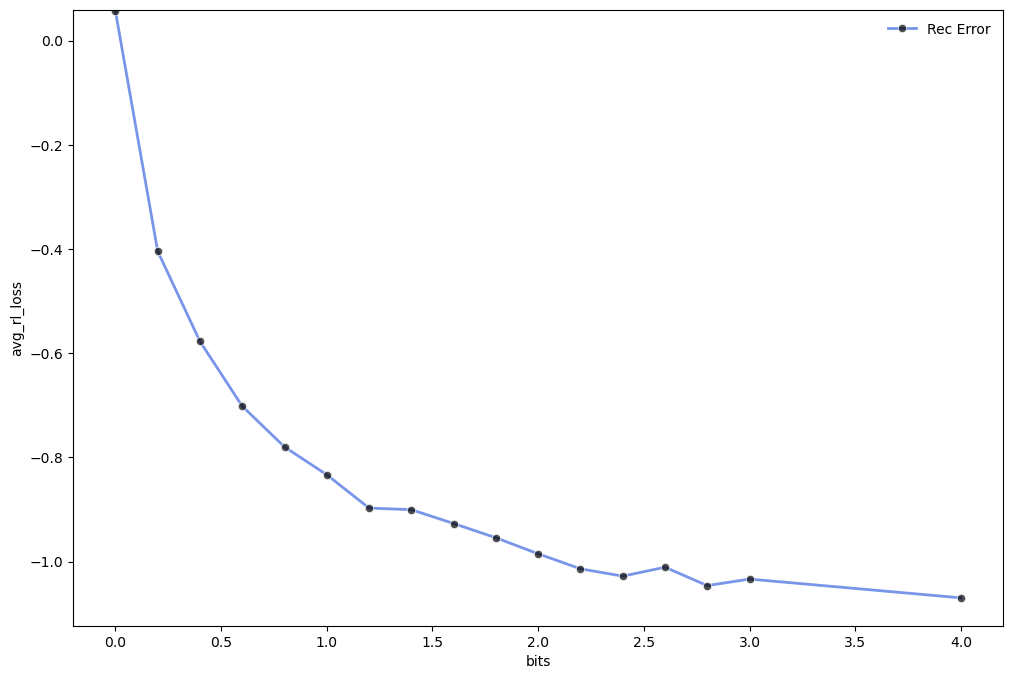

In [23]:
# Plots Rec los vs bits 
fig, ax1 = plt.subplots(figsize=(12,8))
ax1 = sns.lineplot(
            final_df,x=final_df["bits"], y=final_df["avg_rl_loss"],
            lw = 2, color = "royalblue", alpha = 0.7, label="Rec Error",
            marker = "o", markerfacecolor="black")

ax1.set_ylim([
            np.min(final_df["avg_rl_loss"])*1.05,
            np.max(final_df["avg_rl_loss"])*1.05
            ])

ax1.legend(frameon = False, ncol=2)
plt.show()